# How to do the calibration

## Code setup

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import root
import argparse
import numpy as np
import csv
import sys
import os
import math
plt.style.use("../phil.mplstyle")

# The Algorithm

 - The first step is to let the IMU sit at rest for $T_{init}$ seconds. This interval is derived from the Allen Variance metnhod.
 - Also during this initial time interval, measure the average gyro readings in each axis: $\textbf{b}^g$
 - Let the IMU sit at some orientation for 4 seconds, then move it to some other orientation. Repeat this between 36 and 50 times.
 - Iterate over each gyroscope readings and subtract the bias $\text{b}^g$
 - Compute the magnitude of the variance $\varsigma_{init}$ for the accelerometer data over the $T_{init}$. To do this, you iterate over each accelerometer reading during $T_{init}$ and compute the sample variance. This is the average of the variance for each point: $var(a) = (a-\mathbb{E}[a])^2$. Do this for each axis.

#### A quick code example of this part:

In [2]:
x = [1.1, 1.2, 0.9, 0.9, 1.3, 0.8]
expected_value = np.mean(x)
print("expected_value: ", expected_value)
sample_variance = np.mean((x - expected_value)**2)
print("sample variance:", sample_variance)

expected_value:  1.03333333333
sample variance: 0.0322222222222


 - Iterate over a bunch of thresholds and compute how good each one is at calibrating the data. This is what the loop in Algorithm 1 refers to.
   - Set the threshold you're testing to $threshold = i * \varsigma_{init}$
   - Compute the regions of static/dynamic using that threshold
     - Iterate over each window of $t_{wait}$ size in the collected data and compute the sample variance (same as above) and compare to the threshold
     - If it's greater, the you classify as dynamics, otherwise as static
     - The output will be like the black line in Figure 3
   - Do the LM optimization (magic call the Eigen).
     - For this LM, we need to provide a functor that has `int operator()(const Eigen::VectorXf &x, Eigen::VectorXf &fvec) const` and `int df(const Eigen::VectorXf &x, Eigen::MatrixXf &fjac) const`. For `operator()` it should fill `fvec` with the values of the equation $e_k={\lVert g\rVert}^2 - {\lVert T^aK^a(a_k^S+b^a)\rVert}^2$, where ${\lVert g\rVert}^2 = 9.8$. For `df`, you fill `fjac` with each error term $\frac{\partial e_1}{\partial \theta^{acc}}, \dots, \frac{\partial e_k}{\partial \theta^{acc}}$.
      - Compute the residuals for the final optimized parameters
      - Save (residuals, params, threshold, intervals) if they're the best ones so far
 - Calibrate the accelerometer $a^o = T^aK^a(a^S+b^a)$
 - Calibrate the gyroscope using another LM. This time in `int operator()` you fill `fvec` with $\lVert(u_{a,k} - u_{g,k})\rVert$ and also the partials into `fjac`.

## Setting up the Jacobians

Look in `docs/IMU_calibration.pdf`

## Evaluating the accuacy of numerical derivatives

In [3]:
def func(theta_acc):
    T = np.array([[1, -theta_acc[0], theta_acc[1]],[0, 1, -theta_acc[2]],[0,0,1]])
    K = np.array([[theta_acc[3],0,0],[0,theta_acc[4],0],[0,0,theta_acc[5]]])
    b = np.array([[theta_acc[6]],[theta_acc[7]],[theta_acc[8]]])
    return 1 - np.linalg.norm(T@K@(a_i + b))**2

def five_point_approximation(func, theta_acc, h):
    N = theta_acc.shape[1]
    partials = np.ndarray((N,1))
    for partial_idx in range(N):
        hs = np.array([-2*h, -h, h, 2*h])
        nodes = np.repeat(theta_acc, 4, axis=0)
        nodes[:,partial_idx] += hs
        five_point_approx = 1/(12*h)*(func(nodes[0]) - 8*func(nodes[1]) + 8*func(nodes[2]) - func(nodes[3]))
        partials[partial_idx] = five_point_approx
    return partials


# theta_acc = [a_yz, a_zy, a_zx, s_x_a, s_y_a, s_z_a, b_x_a, b_y_a, b_z_a]
theta_acc = np.array([[0.1, 0, 0.1, 1, 1, 1, 0, 0.1, 0]], dtype=np.float32)
a_i = np.array([[0.2], [0.7], [0.1]])
h = 0.1

print("five-point approximations")
print(five_point_approximation(func, theta_acc, h))

five-point approximations
[[ 0.192     ]
 [-0.024     ]
 [ 0.158     ]
 [-0.04800001]
 [-1.24480035]
 [-0.0042    ]
 [-0.24      ]
 [-1.556     ]
 [-0.042     ]]


In [4]:
data_filename = "recorded_sensor_data/imu_calibration/imu_calibration_data_1_28_final.csv"
#data_filename = "recorded_sensor_data/imu_calibration/imu_12_07_nicolette2.csv"
# files where 0.4 and integration works "well"
# "recorded_sensor_data/imu_calibration/imu_12_07_nicolette1.csv"
# "recorded_sensor_data/imu_calibration/imu_12_07_nicolette2.csv"
# "recorded_sensor_data/imu_calibration/imu_calibration_data_11_14.csv"
reader = csv.reader(open(data_filename, 'r'))

next(reader) # skip header
data = []
for row in reader:
    data.append([float(x) for x in row])
data = np.array(data)

In [5]:
print(data.shape)

(33100, 7)


## iterate over the Tinit period to compute the gyro biases

In [6]:
Tinit = 50
samples_per_second = 100
Tinit_idx = int(Tinit * samples_per_second)
init_data = data[:Tinit_idx]
remaining_data = data[Tinit_idx:]
gyro_biases = np.mean(init_data, axis=0)[3:6]
data -= np.array([0, 0, 0, gyro_biases[0], gyro_biases[1], gyro_biases[2], 0])

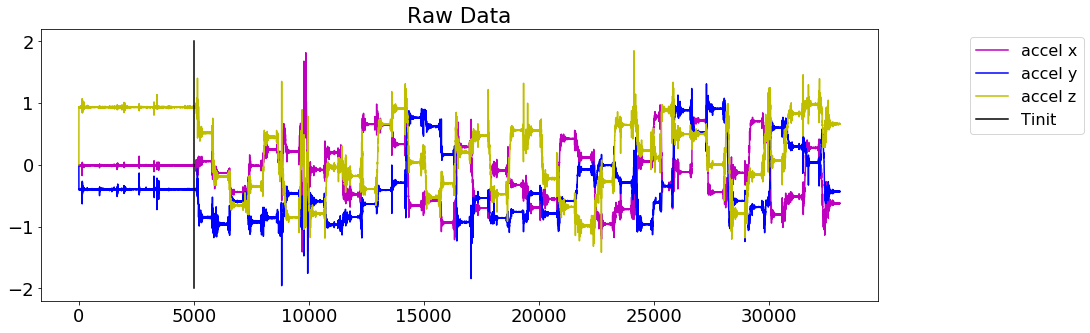

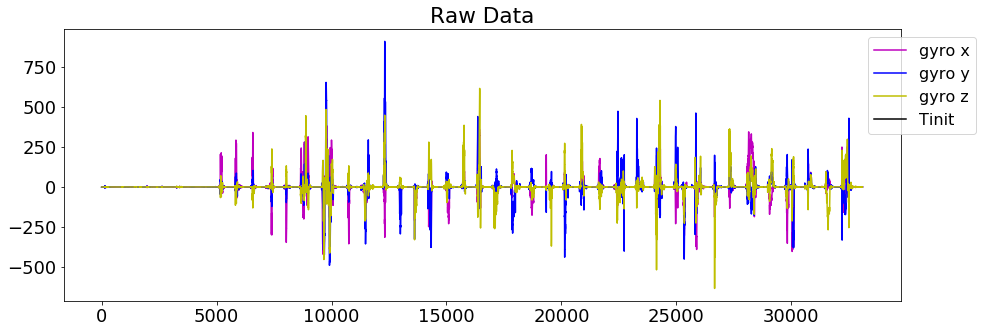

In [7]:
plt.figure(figsize=(15,5))
plt.title("Raw Data")
plt.plot(data[:,0], label='accel x',c='m')
plt.plot(data[:,1], label='accel y', c='b')
plt.plot(data[:,2], label='accel z', c='y')
plt.plot([Tinit*100, Tinit*100], [-2, 2], label="Tinit", c='k')
plt.legend(bbox_to_anchor=(1.1,1))
plt.show()

plt.figure(figsize=(15,5))
plt.title("Raw Data")
plt.plot(data[:,3], label='gyro x',c='m')
plt.plot(data[:,4], label='gyro y', c='b')
plt.plot(data[:,5], label='gyro z', c='y')
plt.plot([Tinit*100, Tinit*100], [-2, 2], label="Tinit", c='k')
plt.legend(bbox_to_anchor=(1.1,1))
plt.show()

In [8]:
def get_static_intervals(threshold, data, t_wait, sample_per_second):
    window_size = int(sample_per_second * t_wait)
    if window_size % 2 == 0:
        window_size -= 1
    data_array_size = len(data)
    classifications = np.zeros(data_array_size)
    static_indicators = []
    temp_pair = [-1, -1]
    previously_static = False
    for i in range(data_array_size - window_size):
        window_data = data[i:i+window_size]
        center = i + window_size // 2
        variance = np.sum(np.var(window_data[:, :3], axis = 0)**2)
        
        #end of a static interval
        static = variance < threshold
        if not static and previously_static:
            temp_pair[1] = center
            static_indicators.append(temp_pair)
            temp_pair = [-1, -1]
        #start of a static intervals
        elif static and not previously_static:
            temp_pair[0] = center
        
        previously_static = static
        classifications[center] = 1 if static else 0
        
    if previously_static:
        print("static at the end")
        temp_pair[1] = data_array_size - window_size // 2 - 1
        static_indicators.append(temp_pair)
    
    return static_indicators, classifications    

In [9]:
def get_corrected_gyro_data(raw_data, theta_gyro):
    gamma_yz = theta_gyro[0]
    gamma_zy = theta_gyro[1]
    gamma_xz = theta_gyro[2]
    gamma_zx = theta_gyro[3]
    gamma_xy = theta_gyro[4]
    gamma_yx = theta_gyro[5]
    s_x = theta_gyro[6]
    s_y = theta_gyro[7]
    s_z = theta_gyro[8]
    T = np.array([[1, -gamma_yz, gamma_zy], [gamma_xz, 1, -gamma_zx], [-gamma_xy, gamma_yx, 1]])
    K = np.array([[s_x, 0, 0], [0, s_y, 0], [0, 0, s_z]])
    
    #corrected frame
    corrected_data = np.ndarray(raw_data.shape)
    for idx, w_s in enumerate(raw_data):
        corrected_data[idx] = (T@K@w_s)
        
    return corrected_data

def expected_acc_frame(intervals, data, theta_gyro, dt, integration_type):
    mean_acc_frames = np.ndarray(shape=(len(intervals), 3), dtype=float)
    midpoints = [(x[1] // 2 + x[0] // 2) for x in intervals]
    expected_final_acc_frames = np.ndarray(shape=(len(intervals) - 1, 3), dtype=float)

    midpoints_plus = [x + Tinit * samples_per_second for x in midpoints]

    for i, x in enumerate(intervals):
        start = x[0]
        end = x[1]
        mean_acc_frames[i] = np.mean(data[start : end + 1, : 3], axis = 0)
    
    
    corrected_gyro_data = get_corrected_gyro_data(data[:, 3:6], theta_gyro)
    
    for index, midpoint in enumerate(midpoints[:-1]):
        start = midpoint
        end = midpoints[index + 1]
        if integration_type == "one-time":
            expected_final_acc_frames[index] = one_time_rotation_integration(mean_acc_frames[index],
                                                              corrected_gyro_data[start : end + 1], dt)
        else:
            expected_final_acc_frames[index] = integrate_gyro(mean_acc_frames[index],
                                                          corrected_gyro_data[start : end + 1], dt)
    
    return mean_acc_frames[1:], expected_final_acc_frames

def integrate_gyro(initial_acc, gyro_data, dt):
    conversion = np.pi / 180
    scale = 1
    for g in gyro_data:
        initial_acc = rotation_matrix(g * dt * conversion * scale) @ initial_acc
    return initial_acc
    
        
def rotation_matrix(gyro_matrix):
    theta_x, theta_y, theta_z = gyro_matrix[0], gyro_matrix[1], gyro_matrix[2]
    
    rotation_matrix_x = np.array([[1, 0, 0]
                                  ,[0, math.cos(theta_x), -math.sin(theta_x)]
                                  ,[0, math.sin(theta_x), math.cos(theta_x)]])
    
    rotation_matrix_y = np.array([[math.cos(theta_y), 0, math.sin(theta_y)]
                                  ,[0, 1, 0]
                                  ,[-math.sin(theta_y), 0, math.cos(theta_y)]])

    rotation_matrix_z = np.array( [[math.cos(theta_z), -math.sin(theta_z), 0]
                                ,[math.sin(theta_z), math.cos(theta_z), 0]
                                ,[0, 0, 1]])
    
    return (rotation_matrix_x @ rotation_matrix_y @ rotation_matrix_z)

def one_time_rotation_integration(initial_acc, gyro_data, dt):
    conversion = np.pi / 180
    total_gyro_data = np.sum(gyro_data,axis=0)
    
    result = rotation_matrix(total_gyro_data * dt * conversion) @ initial_acc
    return result

In [10]:
sigma_init = np.linalg.norm(np.var(init_data[:, :3], axis=0))
print("sigma_init:", sigma_init)

sigma_init: 0.000456814833505


static at the end
The number of total intervals is: 37


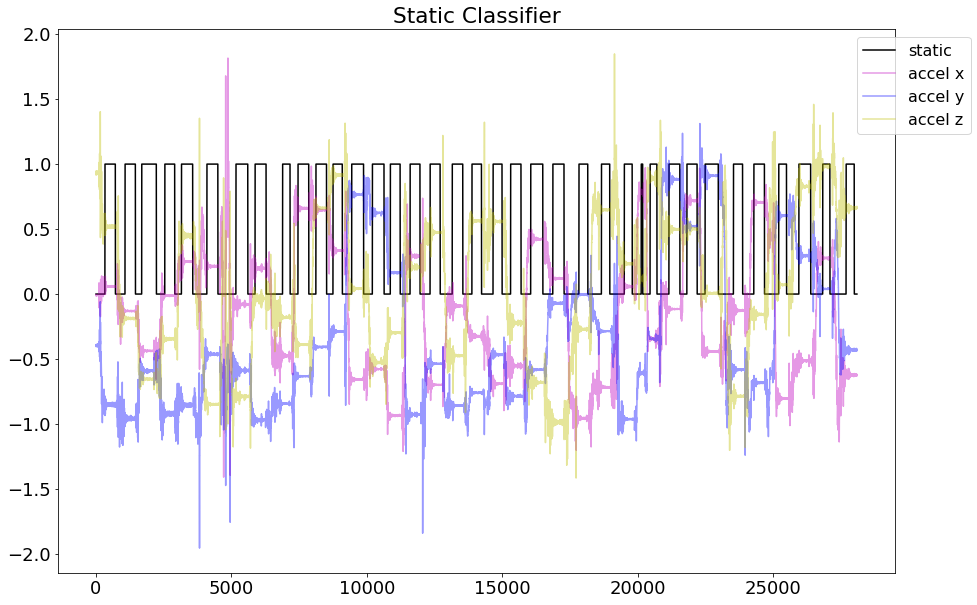

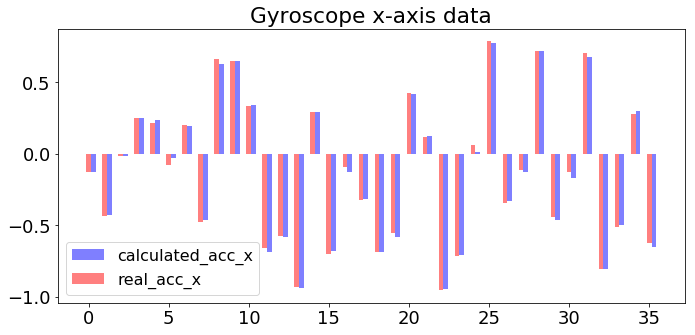

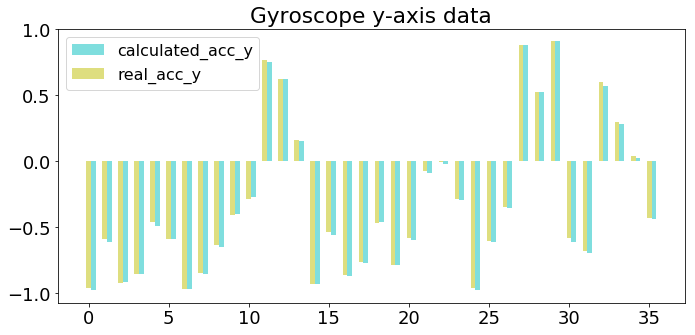

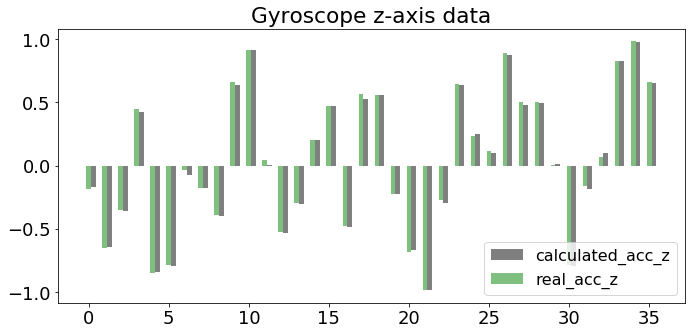

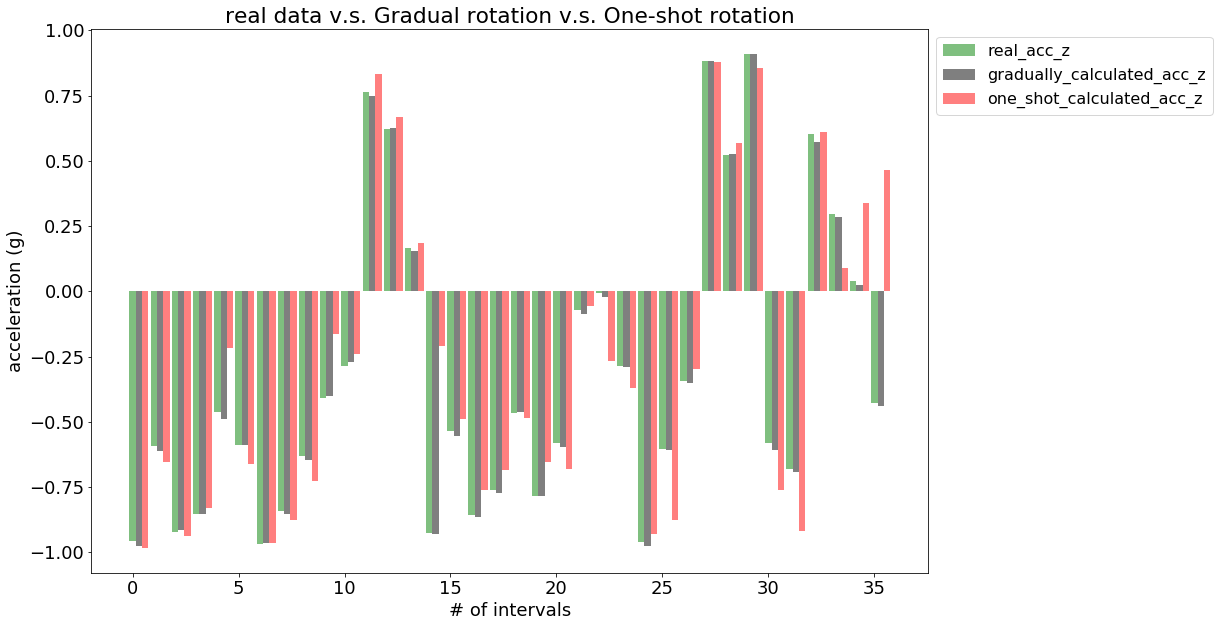

In [19]:
intervals, classifications = get_static_intervals(sigma_init**2*32, remaining_data, 2, samples_per_second)


total_intervals = len(intervals)
print("The number of total intervals is:", total_intervals)

plt.figure(figsize=(15,10))
plt.title("Static Classifier")
plt.plot(classifications, c='k', label="static")
plt.plot(remaining_data[:,0], label='accel x', alpha=0.4, c='m')
plt.plot(remaining_data[:,1], label='accel y', alpha=0.4, c='b')
plt.plot(remaining_data[:,2], label='accel z', alpha=0.4, c='y')
plt.legend(bbox_to_anchor=(1.1,1))
plt.show()
theta_gyro =[0.0084416,0.00196588,-0.00410556,-0.01548901,-0.00191486,
             -0.00770901,0.40658716,0.40275312,0.40165799]
theta_gyro = [0,0,0,0,0,0,0.4,0.4,0.4]

final_acc, expected_acc = expected_acc_frame(intervals, remaining_data, theta_gyro, 0.01, "gradually")
one_time_final_acc, one_time_expected_acc = expected_acc_frame(
    intervals, remaining_data, theta_gyro, 0.01, "one-time")

final_acc_x = final_acc[:,0]
final_acc_y = final_acc[:,1]
final_acc_z = final_acc[:,2]
expected_acc_x = expected_acc[:,0]
expected_acc_y = expected_acc[:,1]
expected_acc_z = expected_acc[:,2]
one_time_expected_acc_x = one_time_expected_acc[:,0]
one_time_expected_acc_y = one_time_expected_acc[:,1]
one_time_expected_acc_z = one_time_expected_acc[:,2]

# data to plot
n_groups = len(final_acc)

# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.5

rects1 = plt.bar(index + bar_width, expected_acc_x, bar_width,
                 alpha=opacity,
                 color='b',
                 label='calculated_acc_x')
rects2 = plt.bar(index, final_acc_x, bar_width,
                 alpha=opacity,
                 color='r',
                 label='real_acc_x')
 


plt.title('Gyroscope x-axis data')
plt.legend()
 
plt.tight_layout()
plt.show()


# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.5

rects1 = plt.bar(index + bar_width, expected_acc_y, bar_width,
                 alpha=opacity,
                 color='c',
                 label='calculated_acc_y')
rects2 = plt.bar(index, final_acc_y, bar_width,
                 alpha=opacity,
                 color='y',
                 label='real_acc_y')
 


plt.title('Gyroscope y-axis data')
plt.legend()
 
plt.tight_layout()
plt.show()


# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.5

rects1 = plt.bar(index + bar_width, expected_acc_z, bar_width,
                 alpha=opacity,
                 color='k',
                 label='calculated_acc_z')
rects2 = plt.bar(index, final_acc_z, bar_width,
                 alpha=opacity,
                 color='g',
                 label='real_acc_z')
 


plt.title('Gyroscope z-axis data')
plt.legend()
 
plt.tight_layout()
plt.show()


# create plot
plt.figure(figsize=(15,10))

index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.5

rects2 = plt.bar(index, final_acc_y, bar_width,
                 alpha=opacity,
                 color='g',
                 label='real_acc_z')
rects1 = plt.bar(index + bar_width, expected_acc_y, bar_width,
                 alpha=opacity,
                 color='k',
                 label='gradually_calculated_acc_z')
rects1 = plt.bar(index + 2 * bar_width, one_time_expected_acc_y , bar_width,
                 alpha=opacity,
                 color='r',
                 label='one_shot_calculated_acc_z')
 


plt.title('real data v.s. Gradual rotation v.s. One-shot rotation')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("# of intervals")
plt.ylabel("acceleration (g)")
plt.show()


In [12]:
def compute_residual(intervals, static_mean_accs, acc_params):
    residual = 0
    for i in range(intervals):
        a_i = static_mean_accs[i]
        residual += acc_loss(a_i, acc_params) ** 2

    return residual

def gyro_loss(accel_frame, previous_accel_frame, raw_gyro_readings, theta_gyro):
    """
    :param accel_frame: u_g_k
    :param previous_accel_frame: u_g_k-1
    :param raw_gyro_readings: raw gyro data between the two accelerometer frames
    :param theta_gyro: parameters for the gyro calibration
    :return:
    """
    def _get_corrected_gyro_data(raw_data, theta_gyro):
        gamma_yz = theta_gyro[0]
        gamma_zy = theta_gyro[1]
        gamma_xz = theta_gyro[2]
        gamma_zx = theta_gyro[3]
        gamma_xy = theta_gyro[4]
        gamma_yx = theta_gyro[5]
        s_x = theta_gyro[6]
        s_y = theta_gyro[7]
        s_z = theta_gyro[8]
        T = np.array([[1, -gamma_yz, gamma_zy], [gamma_xz, 1, -gamma_zx], [-gamma_xy, gamma_yx, 1]])
        K = np.array([[s_x, 0, 0], [0, s_y, 0], [0, 0, s_z]])

        # corrected frame
        # corrected_data = np.ndarray(raw_data.shape)
        # for idx, w_s in enumerate(raw_data):
        #     corrected_data[idx] = (T @ K @ w_s)

        corrected_data = T @ K @ np.expand_dims(raw_data, axis=2)

        return corrected_data

    def _rotation_matrix(gyro_matrix):
        theta_x, theta_y, theta_z = gyro_matrix[0], gyro_matrix[1], gyro_matrix[2]

        cos_theta_x = math.cos(theta_x)
        sin_theta_x = math.sin(theta_x)
        cos_theta_y = math.cos(theta_y)
        sin_theta_y = math.sin(theta_x)
        cos_theta_z = math.cos(theta_z)
        sin_theta_z = math.sin(theta_z)


        rotation_matrix_x = np.array([[1, 0, 0]
                                         , [0, cos_theta_x, -sin_theta_x]
                                         , [0, sin_theta_x, cos_theta_x]])

        rotation_matrix_y = np.array([[cos_theta_y, 0, sin_theta_y]
                                         , [0, 1, 0]
                                         , [-sin_theta_y, 0, cos_theta_y]])

        rotation_matrix_z = np.array([[cos_theta_z, -sin_theta_z, 0]
                                         , [sin_theta_z, cos_theta_z, 0]
                                         , [0, 0, 1]])

        return (rotation_matrix_x @ rotation_matrix_y @ rotation_matrix_z)

    def _integrate_gyro(initial_acc, gyro_data, dt):
        conversion = np.pi / 180
        scale = 1
        for g in gyro_data:
            initial_acc = _rotation_matrix(g * dt * conversion * scale) @ initial_acc
        return initial_acc

    def _expected_acc_frame(acc_frame, raw_gyro_data, theta_gyro, dt):

        corrected_gyro_data = _get_corrected_gyro_data(raw_gyro_data, theta_gyro)
        expected_final_acc_frames = _integrate_gyro(acc_frame, corrected_gyro_data, dt)

        return expected_final_acc_frames
    
    expected_accel_frame =  _expected_acc_frame(previous_accel_frame, raw_gyro_readings, theta_gyro, 0.01)
    return np.linalg.norm(accel_frame / np.linalg.norm(accel_frame) - 
                          expected_accel_frame / np.linalg.norm(expected_accel_frame))


def gyro_loss_derivative(accel_frame, previous_accel_frame, raw_gyro_readings, theta_gyro, h=0.1):
    def func(nodes_):
        return gyro_loss(accel_frame, previous_accel_frame, raw_gyro_readings, nodes_)

    n = theta_gyro.shape[1]
    partials = np.ndarray(n)
    for partial_idx in range(n):
        hs = np.array([-2 * h, -h, h, 2 * h])
        nodes = np.repeat(theta_gyro, 4, axis=0)
        nodes[:, partial_idx] += hs
        five_point_approx = 1 / (12 * h) * (func(nodes[0]) - 8 * func(nodes[1]) + 8 * func(nodes[2]) - func(nodes[3]))
        partials[partial_idx] = five_point_approx
    return partials

def gyro_optimize(num_intervals, static_mean_accs, all_raw_gyro_readings, intervals):
    """
    :param num_intervals: number of static intervals (M)
    :param static_mean_accs: calibrated average accelerometer readings during each static interval
    :param all_raw_gyro_readings: all gyro readings after init period [?X3]
    :param intervals: the range of the detected static intervals [num_intervalsx2]
    :return:
    """
    theta_gyro = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=np.float64)

    # optimization of accelerometer parameters
    def gyro_error_and_jacobian(params):
        # for each static interval
        f = np.zeros(num_intervals)
        df = np.zeros((num_intervals, 9))
        for i in range(1, num_intervals):
            previous_accel_frame = static_mean_accs[i-1]
            accel_frame = static_mean_accs[i]
            raw_gyro_readings = all_raw_gyro_readings[intervals[i-1][1]:intervals[i][0]]
            f[i] = gyro_loss(accel_frame, previous_accel_frame, raw_gyro_readings, params)
            df[i] = gyro_loss_derivative(accel_frame, previous_accel_frame, raw_gyro_readings,
                                         np.expand_dims(params, 0))
        return f, df

    sol = root(gyro_error_and_jacobian, theta_gyro, jac=True, method='lm')
    gyro_params = sol.x

    if not sol.success:
        print("Optimizer Failed: ", sol.message, gyro_params)
    else:
        print(sol.nfev)
    #     print(gyro_params)

#     residual = compute_residual(num_intervals, static_mean_accs, gyro_params)
    residual = []
    return gyro_params, residual


static_mean_accs = np.ndarray((total_intervals, 3))
mean_class = np.copy(remaining_data[:,:3])
for i in range(total_intervals):
    static_interval = intervals[i]
    static_mean_accs[i] = np.mean(remaining_data[static_interval], axis=0)[0:3]
    for j in range(static_interval[0], static_interval[1] + 1):
        mean_class[j] = static_mean_accs[i]


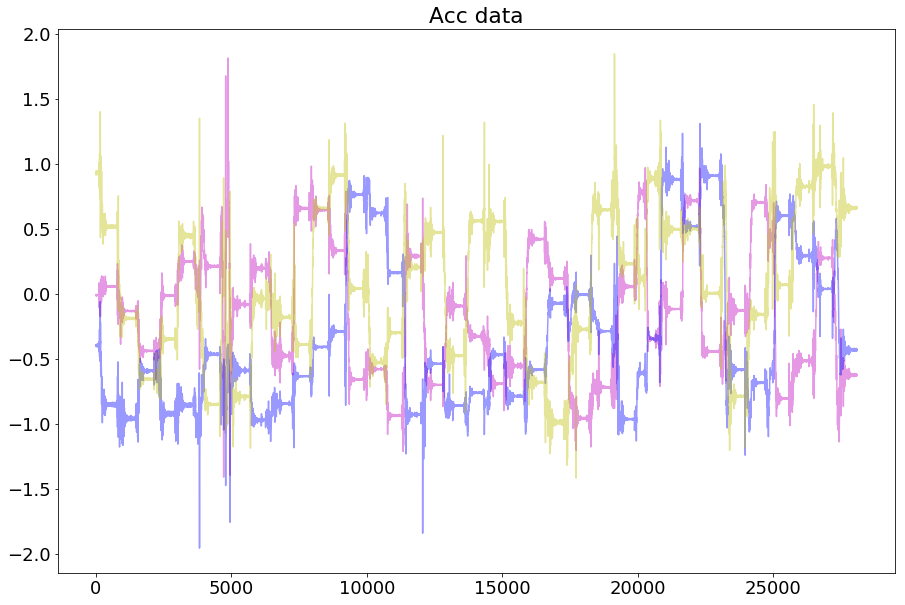

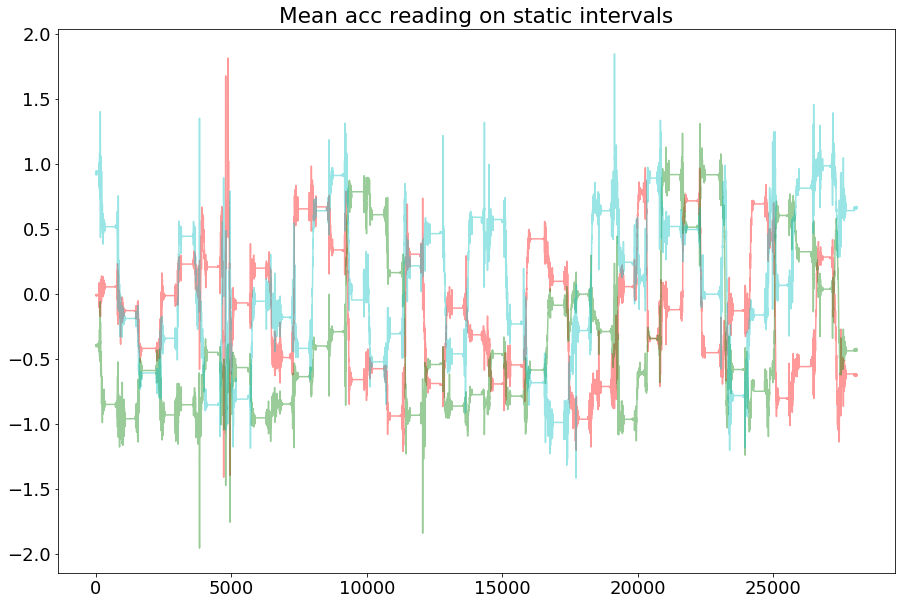

In [13]:
plt.figure(figsize=(15,10))
plt.title("Acc data")
plt.plot(remaining_data[:,0], label='accel x', alpha=0.4, c='m')
plt.plot(remaining_data[:,1], label='accel y', alpha=0.4, c='b')
plt.plot(remaining_data[:,2], label='accel z', alpha=0.4, c='y')
plt.show()

plt.figure(figsize=(15,10))
plt.title("Mean acc reading on static intervals")
plt.plot(mean_class[:,0], label='mean accel x', alpha=0.4, c='r')
plt.plot(mean_class[:,1], label='mean accel y', alpha=0.4, c='g')
plt.plot(mean_class[:,2], label='mean accel z', alpha=0.4, c='c')
plt.show()

### References

- https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf
 - http://eigen.tuxfamily.org/bz_attachmentbase/attachment.cgi?id=395
 - https://medium.com/@sarvagya.vaish/levenberg-marquardt-optimization-part-1-981f5777b1d7
 - https://medium.com/@sarvagya.vaish/levenberg-marquardt-optimization-part-2-5a71f7db27a0
 - https://github.com/SarvagyaVaish/Eigen-Levenberg-Marquardt-Optimization/blob/master/main.cpp

In [14]:
np.set_printoptions(suppress=True)
print(final_acc/np.linalg.norm(final_acc))
print(len(final_acc))
print(expected_acc/np.linalg.norm(expected_acc))


[[-0.02177132 -0.15979912 -0.03127133]
 [-0.07280219 -0.09857982 -0.10879274]
 [-0.0021237  -0.15377289 -0.05774381]
 [ 0.04178049 -0.14264093  0.07508492]
 [ 0.03566954 -0.07716541 -0.1415753 ]
 [-0.01325472 -0.09800654 -0.13131672]
 [ 0.03301446 -0.16153425 -0.00575461]
 [-0.07915643 -0.14076668 -0.02983302]
 [ 0.11005484 -0.10548078 -0.06502863]
 [ 0.10761333 -0.06791933  0.11038763]
 [ 0.05601094 -0.04786334  0.15267296]
 [-0.10961574  0.12761472  0.00688363]
 [-0.09630936  0.10405231 -0.08767889]
 [-0.15591434  0.02742281 -0.04955243]
 [ 0.04870143 -0.1546269   0.03429843]
 [-0.11645933 -0.089514    0.07902162]
 [-0.01543296 -0.14315541 -0.07945235]
 [-0.05400195 -0.12674604  0.09377196]
 [-0.11518622 -0.0777448   0.09302151]
 [-0.09224453 -0.13102609 -0.03717553]
 [ 0.07066779 -0.09715641 -0.1134967 ]
 [ 0.02002303 -0.01186821 -0.1642099 ]
 [-0.15937646 -0.00080027 -0.04511802]
 [-0.11956323 -0.04760143  0.10804749]
 [ 0.00956478 -0.160485    0.03914217]
 [ 0.1312556  -0.10091807